<>:219: SyntaxWarning: invalid escape sequence '\F'
<>:219: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Karimulla\AppData\Local\Temp\ipykernel_1452\983865646.py:219: SyntaxWarning: invalid escape sequence '\F'
  image_path = "E:\Final_Project\lion.png"


Enter the message to hide:  hello


Generated Key: FPsVDLktY3BcINUI

Message embedded successfully! Stego image saved at: E:\Final_Project\stego_image.png


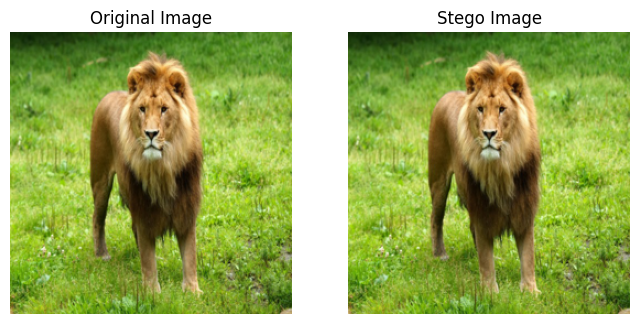


Extracted message: hello

Embedded and extracted messages match!

Performance Metrics:
MSE: 0.0000
PSNR: 102.3162 dB


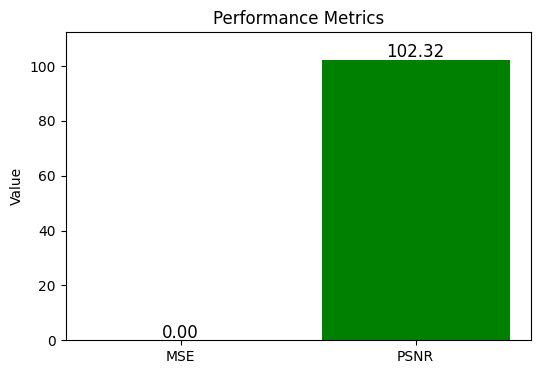

In [2]:
import cv2
import numpy as np
import os
import random
import secrets, string
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Function to generate a magic square (only for odd sizes)
def generate_magic_square(n):
    if n % 2 == 0:
        raise ValueError("Magic square is only implemented for odd sizes.")

    magic_square = [[0] * n for _ in range(n)]
    i, j = 0, n // 2

    for num in range(1, n * n + 1):
        magic_square[i][j] = num
        i_new, j_new = (i - 1) % n, (j + 1) % n
        if magic_square[i_new][j_new]:
            i = (i + 1) % n
        else:
            i, j = i_new, j_new

    return np.array(magic_square)

# Function for MLEA Encryption
def mle_encrypt(data, key):
    random.seed(key)
    data_bits = ''.join(format(ord(char), '08b') for char in data)
    data_bits = list(data_bits)

    # Step 1: XOR all bits with 1
    data_bits = ['1' if bit == '0' else '0' for bit in data_bits]

    # Step 2: Swap first 4 bits with last 4 bits in 8-bit segments
    for i in range(0, len(data_bits), 8):
        if i + 8 <= len(data_bits):
            data_bits[i:i+4], data_bits[i+4:i+8] = data_bits[i+4:i+8], data_bits[i:i+4]

    # Step 3: Left Circular Shift for every 8-bit segment
    for i in range(0, len(data_bits), 8):
        if i + 8 <= len(data_bits):
            shifted = data_bits[i+1:i+8] + [data_bits[i]]
            data_bits[i:i+8] = shifted

    # Step 4: Divide into two blocks B1 and B2
    midpoint = len(data_bits) // 2
    B1 = data_bits[:midpoint]
    B2 = data_bits[midpoint:]

    # Step 5: Perform conditional XOR on B2 using B1
    for i in range(min(len(B1), len(B2))):
        if B1[i] == '1':
            B2[i] = '1' if B2[i] == '0' else '0' # XOR operation

    # Concatenate B1 and modified B2
    encrypted_bits = B1 + B2

    # Convert bits back to characters
    encrypted_data = ''.join(chr(int(''.join(encrypted_bits[i:i+8]), 2)) for i in range(0, len(encrypted_bits), 8))

    return encrypted_data

# Function for MLEA Decryption
def mle_decrypt(data, key):
    random.seed(key)
    data_bits = ''.join(format(ord(char), '08b') for char in data)
    data_bits = list(data_bits)

    # Step 1: Divide into two blocks B1 and B2
    midpoint = len(data_bits) // 2
    B1 = data_bits[:midpoint]
    B2 = data_bits[midpoint:]

    # Step 2: Reverse XOR operation on B2 using B1
    for i in range(min(len(B1), len(B2))):
        if B1[i] == '1':
            B2[i] = '1' if B2[i] == '0' else '0' # XOR operation

    # Step 3: Concatenate B1 and modified B2
    decrypted_bits = B1 + B2

    # Step 4: Reverse Left Circular Shift for every 8-bit segment
    for i in range(0, len(decrypted_bits), 8):
        if i + 8 <= len(decrypted_bits):
            shifted = [decrypted_bits[i+7]] + decrypted_bits[i:i+7]
            decrypted_bits[i:i+8] = shifted

    # Step 5: Reverse Swap (Swap first 4 bits with last 4 bits in each 8-bit block)
    for i in range(0, len(decrypted_bits), 8):
        if i + 8 <= len(decrypted_bits):
            decrypted_bits[i:i+4], decrypted_bits[i+4:i+8] = decrypted_bits[i+4:i+8], decrypted_bits[i:i+4]

    # Step 6: Reverse XOR all bits with 1
    decrypted_bits = ['1' if bit == '0' else '0' for bit in decrypted_bits]

    # Convert bits back to characters
    decrypted_data = ''.join(chr(int(''.join(decrypted_bits[i:i+8]), 2)) for i in range(0, len(decrypted_bits), 8))

    return decrypted_data

# Function to embed encrypted message in the blue channel using a magic square
def embed_message(image_path, message, key):
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    n = min(h, w)
    if n % 2 == 0:
        n -= 1 # make it odd
    magic = generate_magic_square(n)

    # Encrypt the message
    encrypted_message = mle_encrypt(message, key)

    # Convert encrypted message to binary with delimiter
    binary_data = ''.join(format(ord(char), '08b') for char in encrypted_message) + '1111111111111110'
    bin_index = 0

    # Use magic square to guide embedding
    for val in np.nditer(magic):
        i = int((val - 1) / n)
        j = int((val - 1) % n)
        if bin_index < len(binary_data) - 1:
            b_bin = format(img[i, j, 0], '08b')[:-2] + binary_data[bin_index:bin_index+2]
            img[i, j, 0] = int(b_bin, 2)
            bin_index += 2
        else:
            break

    # Save the stego image
    folder = os.path.dirname(image_path)
    stego_image_path = os.path.join(folder, "stego_image.png")
    cv2.imwrite(stego_image_path, img)
    print(f"\nMessage embedded successfully! Stego image saved at: {stego_image_path}")
    
     # Display the image
    display_size = (256,256)
    stego_img = Image.open(stego_image_path).resize(display_size)
    original_img = Image.open(image_path).resize(display_size)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(original_img)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(stego_img)
    axes[1].axis("off")
    axes[1].set_title("Stego Image")

    plt.show()
    
    return stego_image_path
# Function to extract message from the blue channel using the same magic square
def extract_message(stego_image_path, key):
    img = cv2.imread(stego_image_path)
    h, w, _ = img.shape
    n = min(h, w)
    if n % 2 == 0:
        n -= 1
    magic = generate_magic_square(n)

    binary_data = ''

    for val in np.nditer(magic):
        i = int((val - 1) / n)
        j = int((val - 1) % n)
        binary_data += format(img[i, j, 0], '08b')[-2:]

    # Extract encrypted data by removing delimiter
    binary_data = binary_data.split('1111111111111110')[0]
    extracted_text = ''.join(chr(int(binary_data[i:i+8], 2)) for i in range(0, len(binary_data), 8))

    # Decrypt extracted message
    decrypted_message = mle_decrypt(extracted_text, key)
    print("\nExtracted message:", decrypted_message)
    return decrypted_message
# Function to calculate MSE and PSNR
def performance_metrics(original_image_path, stego_image_path):
    original = cv2.imread(original_image_path)
    stego = cv2.imread(stego_image_path)

    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

    # Compute MSE
    mse = np.mean((original_gray - stego_gray) ** 2)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf') # Infinite PSNR if images are identical
    else:
        psnr = 10 * np.log10((255 ** 2) / mse)

    print(f"\nPerformance Metrics:\nMSE: {mse:.4f}\nPSNR: {psnr:.4f} dB")
    # Plot bar chart
    plt.figure(figsize=(6, 4))
    metrics = ['MSE', 'PSNR']
    values = [mse, psnr]

    plt.bar(metrics, values, color=['blue', 'green'])
    plt.ylabel('Value')
    plt.title('Performance Metrics')
    plt.ylim(0, max(values) + 10) # Adjust y-axis limit

    # Show values on bars
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=12)

    plt.show()

    return mse, psnr


    
# Main function
def main():
    image_path = "E:\Final_Project\lion.png"
    message = input("Enter the message to hide: ")
    key = ''.join(secrets.choice(string.ascii_letters + string.digits) for _ in range(16))
    print("Generated Key:", key)

    # Step 1: Embed the message
    stego_image_path = embed_message(image_path, message, key)

    # Step 2: Extract and compare the message
    extracted_message = extract_message(stego_image_path, key)

    # Step 3: Compare embedded and extracted message
    if message == extracted_message:
        print("\nEmbedded and extracted messages match!")
    else:
        print("\nMessages do NOT match! Something went wrong.")

    # Step 4: Calculate Performance Metrics
    performance_metrics(image_path, stego_image_path)

# Run the program
if __name__ == "__main__":
    main()